In [1]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#label encorder
from sklearn import preprocessing

#plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#import plotly.offline as pyo
#import plotly.graph_objs as go
from scipy.stats import pearsonr

from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import numpy as np

#evaluate
from sklearn import metrics

#feature selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from collections import Counter
from sklearn.feature_selection import mutual_info_regression

#grid research
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#punctuation
import string
#stopwords
from sklearn.feature_extraction import text

#for minus value
from sklearn.preprocessing import MinMaxScaler

#prediction for GNB,DecisionTree,LogisticRegression,Perceptron,MLPClassifier,Zero-R
from sklearn import svm
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import time

count                     7678
unique                       8
top       classic pop and rock
freq                      1629
Name: genre, dtype: object
[('classic pop and rock', 1629), ('folk', 1601), ('metal', 1143), ('punk', 937), ('soul and reggae', 930), ('pop', 657), ('dance and electronica', 478), ('jazz and blues', 303)]
null in traindataAll =  [0]
Index([], dtype='object')
{'classic pop and rock': 1629, 'folk': 1601, 'metal': 1143, 'punk': 937, 'soul and reggae': 930, 'pop': 657, 'dance and electronica': 478, 'jazz and blues': 303}
the     6590
to      6258
a       6179
and     6126
i       5904
        ... 
well    1186
or      1166
then    1166
some    1157
mind    1152
Length: 100, dtype: int64


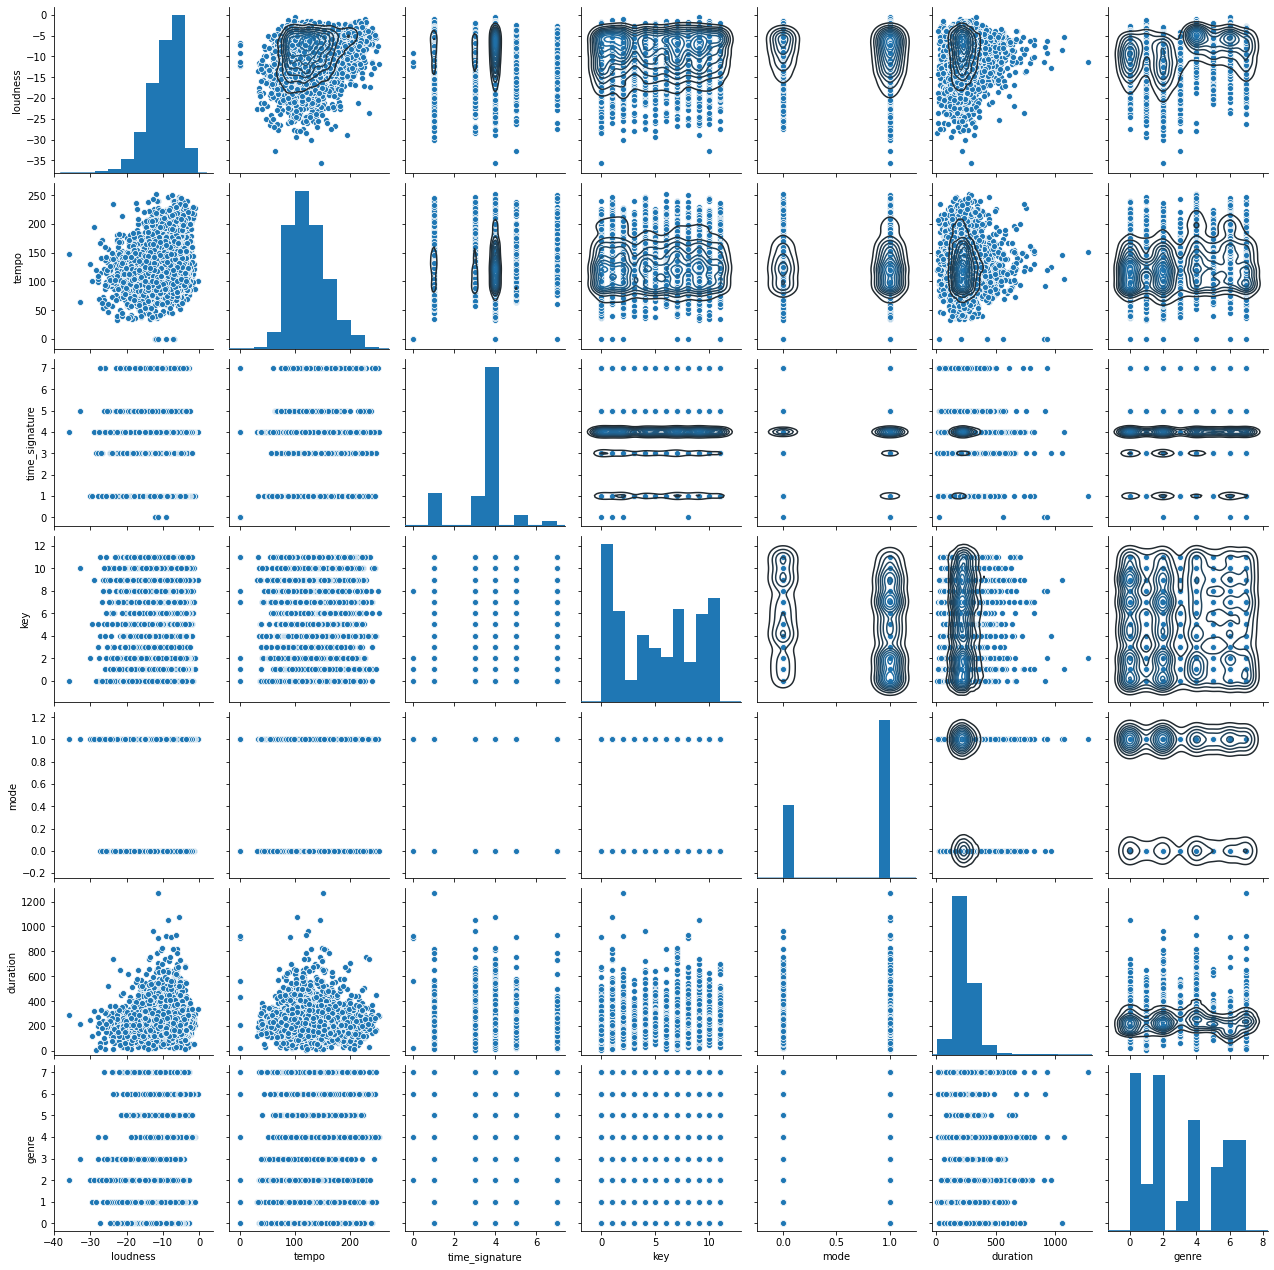

{4: 5129, 1: 1062, 3: 958, 5: 360, 7: 165, 0: 4}
{4: 282, 3: 74, 1: 60, 5: 24, 7: 10}
{4: 284, 3: 53, 1: 53, 5: 27, 7: 10, 0: 1}
{0: 1003, 7: 936, 2: 913, 9: 889, 4: 677, 1: 589, 11: 588, 5: 546, 10: 461, 6: 448, 8: 404, 3: 224}
{9: 63, 7: 58, 0: 51, 2: 49, 11: 44, 4: 36, 10: 35, 1: 32, 5: 25, 6: 22, 3: 20, 8: 15}
{7: 59, 2: 51, 9: 46, 0: 43, 1: 40, 5: 37, 11: 34, 8: 30, 4: 28, 6: 25, 10: 21, 3: 14}


In [2]:
#display correlation coefficient and p value with graph
#def corrfunc(x, y, **kws):
    #(r, p) = pearsonr(x, y)
    #ax = plt.gca()
    #ax.annotate("r = {:.2f} ".format(r),xy=(.1, .9), xycoords=ax.transAxes)
    #ax.annotate("p = {:.3f}".format(p),xy=(.4, .9), xycoords=ax.transAxes)

#check data and plot data
def checkandplotdata():
    #read features from training file
    traindata = pd.read_csv("train_features.csv",header = 0)
    trainlabel = pd.read_csv("train_labels.csv",header = 0)
    #join trainlabel and traindata on trackID and match order
    traindataAll = traindata.join(trainlabel.set_index('trackID'), on='trackID')
    traindata = traindataAll.drop(['trackID','genre'],axis=1)
    trainlabel = traindataAll['genre']
    
    print(trainlabel.describe())
    # Sort most common values
    cnt = Counter(trainlabel)
    print(cnt.most_common())
    #any null?
    print('null in traindataAll = ', traindataAll.isnull().sum(axis = 0).unique())
    #data type in traindata
    traindataAll.dtypes.value_counts()
    #check constant value in column?
    print(traindataAll.columns[traindataAll.nunique() <= 1])
    #get unique genre list
    print(traindataAll['genre'].value_counts().to_dict())
    
    #most frequent words in title
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    print(pd.Series(' '.join(traindata['tags']).translate(translator).lower().split()).value_counts()[:100])
    
    #label encorder
    le = preprocessing.LabelEncoder()
    traindataAll['genre'] = le.fit_transform(traindataAll['genre'])
    
    #plot data seaborn
    #sns.pairplot(pd.concat([traindataAll.iloc[:,3:9],traindataAll['genre']],axis=1)).map(corrfunc).map_lower(sns.scatterplot).map_upper(sns.kdeplot).map_diag(sns.kdeplot)
    sns.pairplot(pd.concat([traindataAll.iloc[:,3:9],traindataAll['genre']],axis=1)).map_lower(sns.scatterplot).map_upper(sns.kdeplot).map_diag(sns.kdeplot)
    plt.show()
    
    #pyo.init_notebook_mode()
    #data = [go.Histogram(x = trainlabel)]
    #pyo.iplot(figure_or_data= data, filename='Histogram_Target')
    
    #read valid data and test data
    validdata = pd.read_csv("valid_features.csv",header = 0)
    testdata = pd.read_csv("test_features.csv",header = 0)
    
    #check time signature and key in valid and test data have every categorical value that train data has
    print(traindata['time_signature'].value_counts().to_dict())
    print(validdata['time_signature'].value_counts().to_dict())
    print(testdata['time_signature'].value_counts().to_dict())
    
    print(traindata['key'].value_counts().to_dict())
    print(validdata['key'].value_counts().to_dict())
    print(testdata['key'].value_counts().to_dict())
    
    #transform title and tag to dummy variables
    #title transformation
    vectorizerTitle = CountVectorizer()
    traindataTitleVec = pd.DataFrame(vectorizerTitle.fit_transform(traindata['title']).toarray(),columns=vectorizerTitle.get_feature_names())
    vectorizerTitle = CountVectorizer()
    validdataTitleVec = pd.DataFrame(vectorizerTitle.fit_transform(validdata['title']).toarray(),columns=vectorizerTitle.get_feature_names())
    vectorizerTitle = CountVectorizer()
    testdataTitleVec = pd.DataFrame(vectorizerTitle.fit_transform(testdata['title']).toarray(),columns=vectorizerTitle.get_feature_names())
    
checkandplotdata()

In [2]:
#best feature selection, return column names of kbest
def KBestSelectFeatures(label,method,kval,data):
    kbest = SelectKBest(method, k=kval)
    kbest.fit_transform(data, label)
    kbestCols = data.columns[kbest.get_support()]
    return kbestCols

In [3]:
#check difference in column names and add different columns to make them same shapes
def adjustDiff(kbestCols,data):
    #delete columns not in kbestCols
    newdata = data[set(kbestCols).intersection(data.columns)]
    #add columns not in data
    for i in set(kbestCols)-set(data.columns):
        newdata.insert(0,i,[0]*len(newdata.index))
    #sort same order as kbestCols
    newdata = newdata[kbestCols]
    #print(kbestCols == newdata.columns)
    return newdata

In [4]:
#main
def preprocess():
    #read features from train file, validation data and test file
    traindata = pd.read_csv("train_features.csv",header = 0)
    trainlabel = pd.read_csv("train_labels.csv",header = 0)
    
    validdata = pd.read_csv("valid_features.csv",header = 0)
    validlabel = pd.read_csv("valid_labels.csv",header = 0)
    
    testdata = pd.read_csv("test_features.csv",header = 0)
    
    #join trainlabel/validlabel and traindata/validdata on trackID and match order
    traindataAll = traindata.join(trainlabel.set_index('trackID'), on='trackID')
    traindata = traindataAll.drop(['trackID','genre'],axis=1)
    trainlabel = traindataAll['genre']
    
    validdataAll = validdata.join(validlabel.set_index('trackID'), on='trackID')
    validdata = validdataAll.drop(['trackID','genre'],axis=1)
    
    #label encorder
    le = preprocessing.LabelEncoder()
    le.fit(trainlabel)
    trainlabel = le.transform(traindataAll['genre'])
    validlabel = le.transform(validdataAll['genre'])
    
    #qcut numerical to range
    traindatabin = pd.DataFrame()
    validdatabin = pd.DataFrame()
    testdatabin = pd.DataFrame()
    traindatabin["loudness"],loudBins = pd.qcut(traindata["loudness"],10,retbins=True,labels=False)
    validdatabin["loudness"] = pd.cut(validdata["loudness"],bins=loudBins, labels=False, include_lowest=True)
    testdatabin["loudness"] = pd.cut(testdata["loudness"],bins=loudBins, labels=False, include_lowest=True)
    
    traindatabin["tempo"],tempoBins = pd.qcut(traindata["tempo"],10,retbins=True,labels=False)
    validdatabin["tempo"] = pd.cut(validdata["tempo"],bins=tempoBins, labels=False, include_lowest=True)
    testdatabin["tempo"] = pd.cut(testdata["tempo"],bins=tempoBins, labels=False, include_lowest=True)
    
    traindatabin["duration"],duraBins = pd.qcut(traindata["duration"],10,retbins=True,labels=False)
    validdatabin["duration"] = pd.cut(validdata["duration"],bins=duraBins, labels=False, include_lowest=True)
    testdatabin["duration"] = pd.cut(testdata["duration"],bins=duraBins, labels=False, include_lowest=True)
    
    audioCols = traindata.iloc[:,8:156].columns
  
    for x in audioCols:
        traindatabin[x],abins = pd.qcut(traindata[x],10,retbins=True,labels=False)
        #if valid or text min or max is out of range
        if abins[0] > validdata[x].min():
            abins[0] = validdata[x].min()
        if abins[-1] < validdata[x].max():
            abins[-1] = validdata[x].max()
        validdatabin[x] = pd.cut(validdata[x],bins=abins, labels=False, include_lowest=True)
        if abins[0] > testdata[x].min():
            abins[0] = testdata[x].min()
        if abins[-1] < testdata[x].max():
            abins[-1] = testdata[x].max()
        testdatabin[x] = pd.cut(testdata[x],bins=abins, labels=False, include_lowest=True)
    
    #transform audio value to without minus
    scaler = MinMaxScaler()
    traindata[['loudness','tempo','time_signature','duration']] = scaler.fit_transform(traindata[['loudness','tempo','time_signature','duration']])
    validdata[['loudness','tempo','time_signature','duration']] = scaler.fit_transform(validdata[['loudness','tempo','time_signature','duration']])
    testdata[['loudness','tempo','time_signature','duration']] = scaler.fit_transform(testdata[['loudness','tempo','time_signature','duration']])
    
    traindata.iloc[:,8:156] = scaler.fit_transform(traindata.iloc[:,8:156])
    validdata.iloc[:,8:156] = scaler.fit_transform(validdata.iloc[:,8:156])
    testdata.iloc[:,9:157] = scaler.fit_transform(testdata.iloc[:,9:157])
    
    #transform time_signature, key to dummy variables
    #traindataTimesignDummy = pd.get_dummies(traindata['time_signature'], prefix='time_signature', drop_first=True)
    traindataKeyDummy = pd.get_dummies(traindata['key'], prefix='key', drop_first=True)

    #validdataTimesignDummy = pd.get_dummies(validdata['time_signature'], prefix='time_signature')
    validdataKeyDummy = pd.get_dummies(validdata['key'], prefix='key')
    
    #testdataTimesignDummy = pd.get_dummies(testdata['time_signature'], prefix='time_signature')
    testdataKeyDummy = pd.get_dummies(testdata['key'], prefix='key')
    
    #transform title and tag to dummy variables
    #title transformation
    stopWords = text.ENGLISH_STOP_WORDS
    vectorizerTitle = TfidfVectorizer(stop_words=stopWords)
    traindataTitleVec = pd.DataFrame(vectorizerTitle.fit_transform(traindata['title']).toarray(),columns=vectorizerTitle.get_feature_names())
    vectorizerTitle = TfidfVectorizer(stop_words=stopWords)
    validdataTitleVec = pd.DataFrame(vectorizerTitle.fit_transform(validdata['title']).toarray(),columns=vectorizerTitle.get_feature_names())
    vectorizerTitle = TfidfVectorizer(stop_words=stopWords)
    testdataTitleVec = pd.DataFrame(vectorizerTitle.fit_transform(testdata['title']).toarray(),columns=vectorizerTitle.get_feature_names())
    
    #tags transformation
    vectorizerTags = TfidfVectorizer(stop_words=stopWords)
    traindataTagsVec = pd.DataFrame(vectorizerTags.fit_transform(traindata['tags']).toarray(),columns=vectorizerTags.get_feature_names())
    vectorizerTags = TfidfVectorizer(stop_words=stopWords)
    validdataTagsVec = pd.DataFrame(vectorizerTags.fit_transform(validdata['tags']).toarray(),columns=vectorizerTags.get_feature_names())
    vectorizerTags = TfidfVectorizer(stop_words=stopWords)
    testdataTagsVec = pd.DataFrame(vectorizerTags.fit_transform(testdata['tags']).toarray(),columns=vectorizerTags.get_feature_names())
    
    
    #chi square feature selection to title and tags, kbest = 50
    #title feature names array from traindata
    kbestTitleCols = KBestSelectFeatures(trainlabel,chi2,500,traindataTitleVec)
    #tags feature names array from traindata
    kbestTagsCols = KBestSelectFeatures(trainlabel,chi2,500,traindataTagsVec)
    
    #chi feature slection to audio features#100
    kbestAudiosCols = KBestSelectFeatures(trainlabel,chi2,100,traindata.iloc[:,8:156])
    
    #most frequent words for title and text top 50
    titleFreqCols = pd.DataFrame({'title':traindataTitleVec.columns,'count':np.sum(traindataTitleVec.values, axis=0)}).nlargest(30, 'count')['title'].values.tolist()
    tagFreqCols = pd.DataFrame({'tag':traindataTagsVec.columns,'count':np.sum(traindataTagsVec.values, axis=0)}).nlargest(30, 'count')['tag'].values.tolist()
    
    #splits data into 3 features types: meta,text,audio
    #except title and tag    
    traindataOut = {}
    traindataOut['allTitle'] = traindataTitleVec
    traindataOut['titleOnly'] =  traindataTitleVec[kbestTitleCols]
    traindataOut['meta'] =  pd.concat([traindata[['loudness','tempo','time_signature','mode','duration']],traindataKeyDummy,traindataOut['titleOnly']], axis=1)
    traindataOut['metaWithoutTitle'] =  traindata[['loudness','tempo','time_signature','key','mode','duration']]
    traindataOut['metaWithoutKey'] =  pd.concat([traindata[['loudness','tempo','time_signature','mode','duration']],traindataOut['titleOnly']], axis=1)
    traindataOut['audio'] = traindata[kbestAudiosCols]
    traindataOut['allAudio'] = traindata.iloc[:,8:156]
    traindataOut['audioAndLTD'] = pd.concat([traindata[['loudness','tempo','duration']],traindata.iloc[:,8:156]],axis=1)
    traindataOut['text'] = traindataTagsVec[kbestTagsCols]
    traindataOut['allText'] = traindataTagsVec
    traindataOut['titleFreq'] = traindataTitleVec[titleFreqCols]
    traindataOut['tagFreq'] = traindataTagsVec[tagFreqCols]
    traindataOut['numBins'] = traindatabin
    traindataOut['kbestNumBins'] = pd.concat([traindatabin[kbestAudiosCols],traindatabin[['loudness','tempo','duration']]],axis=1)
    traindataOut['label'] = trainlabel
    traindataOut['trackID'] = traindataAll['trackID']
    
    validdataOut = {}
    validdataOut['allTitle'] = adjustDiff(traindataTitleVec.columns,validdataTitleVec)
    validdataOut['titleOnly'] = adjustDiff(kbestTitleCols,validdataTitleVec)
    validdataOut['meta'] = pd.concat([validdata[['loudness','tempo','time_signature','mode','duration']],adjustDiff(traindataKeyDummy.columns,validdataKeyDummy),validdataOut['titleOnly']], axis=1)
    validdataOut['metaWithoutTitle'] =  validdata[['loudness','tempo','time_signature','key','mode','duration']]
    validdataOut['metaWithoutKey'] = pd.concat([validdata[['loudness','tempo','time_signature','mode','duration']],validdataOut['titleOnly']], axis=1)
    validdataOut['audio'] = validdata[kbestAudiosCols]
    validdataOut['allAudio'] = validdata.iloc[:,8:156]
    validdataOut['audioAndLTD'] = pd.concat([validdata[['loudness','tempo','duration']],validdata.iloc[:,8:156]],axis=1)
    validdataOut['text'] = adjustDiff(kbestTagsCols,validdataTagsVec)
    validdataOut['allText'] = adjustDiff(traindataTagsVec.columns,validdataTagsVec)
    validdataOut['titleFreq'] = adjustDiff(titleFreqCols,validdataTitleVec)
    validdataOut['tagFreq'] = adjustDiff(tagFreqCols,validdataTagsVec)
    validdataOut['numBins'] = validdatabin
    validdataOut['kbestNumBins'] = pd.concat([validdatabin[kbestAudiosCols],validdatabin[['loudness','tempo','duration']]],axis=1)
    validdataOut['label'] = validlabel
    validdataOut['trackID'] = validdataAll['trackID']
    
    testdataOut = {}
    testdataOut['allTitle'] = adjustDiff(traindataTitleVec.columns,testdataTitleVec)
    testdataOut['titleOnly'] = adjustDiff(kbestTitleCols,testdataTitleVec)
    testdataOut['meta'] = pd.concat([testdata[['loudness','tempo','time_signature','mode','duration']],adjustDiff(traindataKeyDummy.columns,testdataKeyDummy),testdataOut['titleOnly']], axis=1)
    testdataOut['metaWithoutTitle'] =  testdata[['loudness','tempo','time_signature','key','mode','duration']]
    testdataOut['metaWithoutKey'] = pd.concat([testdata[['loudness','tempo','time_signature','mode','duration']],testdataOut['titleOnly']], axis=1)
    testdataOut['audio'] = testdata[kbestAudiosCols]
    testdataOut['allAudio'] = testdata.iloc[:,9:157]
    testdataOut['audioAndLTD'] = pd.concat([testdata[['loudness','tempo','duration']],testdata.iloc[:,9:157]],axis=1)
    testdataOut['text'] = adjustDiff(kbestTagsCols,testdataTagsVec)
    testdataOut['allText'] = adjustDiff(traindataTagsVec.columns,testdataTagsVec)
    testdataOut['titleFreq'] = adjustDiff(titleFreqCols,testdataTitleVec)
    testdataOut['tagFreq'] = adjustDiff(tagFreqCols,testdataTagsVec)
    testdataOut['numBins'] = testdatabin
    testdataOut['kbestNumBins'] = pd.concat([testdatabin[kbestAudiosCols],testdatabin[['loudness','tempo','duration']]],axis=1)
    testdataOut['trackID'] = testdata['trackID']
    
    return traindataOut, validdataOut, testdataOut, le

traindata, validdata, testdata, le = preprocess()
print(traindata, validdata, testdata)

{'allTitle':        00  000   01  01e   02   03   10  100  1000  101  ...  zoo  zoomin  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  ...     ...   
7673  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
7674  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
7675  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
7676  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   
7677  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0     0.0   

      zorro  zos  zéro  ésto  été  ölürüm  única  üzülme  
0  

In [15]:
#choose best kbest value
def choosek(method,traindata,trainlabel,krange):
    kbest = SelectKBest(method) 
    pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression(max_iter=2000))]) 
    gs = GridSearchCV(pipeline, 
                      scoring='accuracy',
                      cv=3,
                      n_jobs=-1,
                      verbose=1,
                      param_grid = {'kbest__k': krange}#, 'lr__C': np.logspace(-3,3,7)
                              ) 
    gs.fit(traindata, trainlabel)
    print('best_params for Logistic Regression', gs.best_params_)
    print('score',gs.best_score_)
    
    kbest = SelectKBest(method) 
    pipeline = Pipeline([('kbest', kbest), ('dr', DecisionTreeClassifier())]) 
    gs = GridSearchCV(pipeline, 
                      scoring='accuracy',
                      cv=3,
                      n_jobs=-1,
                      verbose=1,
                      param_grid = {'kbest__k': krange}
                              ) 
    gs.fit(traindata, trainlabel)
    print('best_params for Decision Tree', gs.best_params_)
    print('score',gs.best_score_)
    
    
    kbest = SelectKBest(method) 
    pipeline = Pipeline([('kbest', kbest), ('mlp', MLPClassifier(max_iter=2000))]) 
    gs = GridSearchCV(pipeline, 
                      scoring='accuracy',
                      cv=3,
                      n_jobs=-1,
                      verbose=1,
                      param_grid = {'kbest__k': krange}
                              ) 
    gs.fit(traindata, trainlabel)
    print('best_params for MLP', gs.best_params_)
    print('score',gs.best_score_)
    
    
choosek(chi2,traindata['allAudio'],traindata['label'],range(10,150,10))#148,140,146
#choosek(chi2,traindata['allTitle'],traindata['label'],range(100,5000,500))#4600,4400,
#choosek(chi2,traindata['allText'],traindata['label'],range(100,3000,500))#2000
#choosek(chi2,pd.concat([traindata['allAudio'],traindata['allText']],axis=1),traindata['label'],range(100,3000,500))

In [5]:
def train(model,traindata,trainlabel,validdata,validlabel):
    model.fit(traindata,trainlabel)
    acc, pred = predict(model,validdata,validlabel)
    return acc, pred

In [6]:
def predict(model,validdata,validlabel):
    pred = model.predict(validdata)
    acc = evaluate(model,validdata,validlabel)
    return acc, pred

In [7]:
def evaluate(model,validdata,validlabel):
    acc = model.score(validdata,validlabel)
    return acc

In [8]:
#make prediction with GNB,DecisionTree,LogisticRegression,Perceptron,MLPClassifier,Zero-R

def prediction(traindata, trainlabel, validdata, validlabel,fname,predicted):
    models = [DummyClassifier(strategy='most_frequent'),
              GaussianNB(),
              MultinomialNB(),
              KNeighborsClassifier(),
              Perceptron(),
              DecisionTreeClassifier(),
              MLPClassifier(max_iter=2000),
              LogisticRegression(max_iter=2000)]
    titles = ['Zero-R','GNB','MNB','KNN','Perceptron','DecisionTreeClassifier','MLPClassifier','Logistic Regression']
    #score evaluation strategy
    print(fname)
    predicted[fname] = {}
    for title, model in zip(titles,models):
        #start = time.time()
        #acc = model.score(validdata,validlabel)
        acc,pred = train(model,traindata,trainlabel,validdata,validlabel)
        confusion = metrics.confusion_matrix(validlabel, pred)
        #acc = np.mean(cross_val_score(model, X, y, cv=10))
        #end = time.time()
        #t = end - start
        #print('time:', t)
        print(title, "Accuracy:",acc)
        print(title, "confusion:\n",confusion)
        predicted[fname][title] = acc
     
    return predicted

In [9]:
#run prediction

predicted = {}
#kbest audio 
predicted = prediction(traindata['audio'],traindata['label'],validdata['audio'],validdata['label'],'kbestaudio',predicted)
#all audio 
predicted = prediction(traindata['allAudio'],traindata['label'],validdata['allAudio'],validdata['label'],'allAudio',predicted)
#allaudio,loudness,tempo,duration
predicted = prediction(traindata['audioAndLTD'],traindata['label'],validdata['audioAndLTD'],validdata['label'],'allaudio Loudness Ttempo Duration',predicted)
#kbest title
predicted = prediction(traindata['titleOnly'],traindata['label'],validdata['titleOnly'],validdata['label'],'kbesttitle',predicted)
#all title 
predicted = prediction(traindata['allTitle'],traindata['label'],validdata['allTitle'],validdata['label'],'allTitle',predicted)
#freq based title 
#predicted = prediction(traindata['titleFreq'],traindata['label'],validdata['titleFreq'],validdata['label'],'titleFreq',predicted)
#kbest meta
predicted = prediction(traindata['meta'],traindata['label'],validdata['meta'],validdata['label'],'metadata with kbesttitle',predicted)
#metaWithoutTitle
predicted = prediction(traindata['metaWithoutTitle'],traindata['label'],validdata['metaWithoutTitle'],validdata['label'],'metaWithoutTitle',predicted)
#metaWithFreqBasedTitle 
#predicted = prediction(pd.concat([traindata['metaWithoutTitle'],traindata['titleFreq']],axis=1),traindata['label'],pd.concat([validdata['metaWithoutTitle'],validdata['titleFreq']],axis=1),validdata['label'],'metaWithFreqBasedTitle',predicted)
#meta with all Title
predicted = prediction(pd.concat([traindata['metaWithoutTitle'],traindata['allTitle']],axis=1),traindata['label'],pd.concat([validdata['metaWithoutTitle'],validdata['allTitle']],axis=1),validdata['label'],'meta with all Title',predicted)
#kbest text 
predicted = prediction(traindata['text'],traindata['label'],validdata['text'],validdata['label'],'kbesttext',predicted)
#freq based text #0.3666
#predicted = prediction(traindata['tagFreq'],traindata['label'],validdata['tagFreq'],validdata['label'],'tagFreq',predicted)
#all text
predicted = prediction(traindata['allText'],traindata['label'],validdata['allText'],validdata['label'],'allText',predicted)
#numbins
predicted = prediction(traindata['numBins'],traindata['label'],validdata['numBins'],validdata['label'],'numBins',predicted)
#kbest numbins
predicted = prediction(traindata['kbestNumBins'],traindata['label'],validdata['kbestNumBins'],validdata['label'],'kbestnumBins',predicted)
#alltext and allmeta #0.6111
predicted = prediction(pd.concat([traindata['allText'],pd.concat([traindata['metaWithoutTitle'],traindata['allTitle']],axis=1)],axis=1),traindata['label'],pd.concat([validdata['allText'],pd.concat([validdata['metaWithoutTitle'],validdata['allTitle']],axis=1)],axis=1),validdata['label'],'alltext and allmeta',predicted)
#allmeta and allaudio #0.54
predicted = prediction(pd.concat([pd.concat([traindata['metaWithoutTitle'],traindata['allTitle']],axis=1),traindata['allAudio']],axis=1),traindata['label'],pd.concat([pd.concat([validdata['metaWithoutTitle'],validdata['allTitle']],axis=1),validdata['allAudio']],axis=1),validdata['label'],'allmeta and allaudio',predicted)
#allaudio and alltext #0.66
predicted = prediction(pd.concat([traindata['allAudio'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['allAudio'],validdata['allText']],axis=1),validdata['label'],'allaudio and alltext',predicted)
#numBins and alltext
predicted = prediction(pd.concat([traindata['numBins'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['allText']],axis=1),validdata['label'],'numBins and alltext',predicted)
#kbestNumBins and alltext
predicted = prediction(pd.concat([traindata['kbestNumBins'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['kbestNumBins'],validdata['allText']],axis=1),validdata['label'],'kbestNumBins and alltext',predicted)
#audio bins and alltext 
predicted = prediction(pd.concat([traindata['numBins'].drop(['loudness','tempo','duration'],axis=1),traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['numBins'].drop(['loudness','tempo','duration'],axis=1),validdata['allText']],axis=1),validdata['label'],'audioBins and allText',predicted)
#numbins and time signature and alltext
predicted = prediction(pd.concat([traindata['numBins'],traindata['meta']['time_signature'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['meta']['time_signature'],validdata['allText']],axis=1),validdata['label'],'audioBins and timesign and alltext',predicted)
#num bins and time signature and mode and alltext
predicted = prediction(pd.concat([traindata['numBins'],traindata['meta'][['time_signature','mode']],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['meta'][['time_signature','mode']],validdata['allText']],axis=1),validdata['label'],'audioBins and time sign and mode and alltext',predicted)
#allaudio and allText 
predicted = prediction(pd.concat([traindata['allAudio'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['allAudio'],validdata['allText']],axis=1),validdata['label'],'allaudio and alltext',predicted)
#allaudio and allTitle 
predicted = prediction(pd.concat([traindata['allAudio'],traindata['allTitle']],axis=1),traindata['label'],pd.concat([validdata['allAudio'],validdata['allTitle']],axis=1),validdata['label'],'allaudio and alltitle',predicted)
#allaudio and allTitle and allText 
predicted = prediction(pd.concat([traindata['allAudio'],traindata['allTitle'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['allAudio'],validdata['allTitle'],validdata['allText']],axis=1),validdata['label'],'allaudio and alltitle and alltext',predicted)
#allaudio and alltext and metaWithoutTitle
predicted = prediction(pd.concat([traindata['metaWithoutTitle'],traindata['allAudio'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['metaWithoutTitle'],validdata['allAudio'],validdata['allText']],axis=1),validdata['label'],'allaudio and alltext and metaWithoutTitle',predicted)
#all 
predicted = prediction(pd.concat([pd.concat([traindata['metaWithoutTitle'],traindata['allTitle']],axis=1),traindata['allAudio'],traindata['allText']],axis=1),traindata['label'],pd.concat([pd.concat([validdata['metaWithoutTitle'],validdata['allTitle']],axis=1),validdata['allAudio'],validdata['allText']],axis=1),validdata['label'],'all',predicted)

kbestaudio
Zero-R Accuracy: 0.12222222222222222
Zero-R confusion:
 [[55  0  0  0  0  0  0  0]
 [45  0  0  0  0  0  0  0]
 [64  0  0  0  0  0  0  0]
 [44  0  0  0  0  0  0  0]
 [66  0  0  0  0  0  0  0]
 [74  0  0  0  0  0  0  0]
 [44  0  0  0  0  0  0  0]
 [58  0  0  0  0  0  0  0]]
GNB Accuracy: 0.19777777777777777
GNB confusion:
 [[ 0 10  0 44  0  1  0  0]
 [ 0 29  0 11  0  1  0  4]
 [ 1 16  2 42  0  2  1  0]
 [ 0 17  0 23  0  1  3  0]
 [ 0 45  0  1 15  0  1  4]
 [ 0 22  4 37  0  6  0  5]
 [ 0 14  2  9  8  2  9  0]
 [ 0 45  0  8  0  0  0  5]]
MNB Accuracy: 0.33555555555555555
MNB confusion:
 [[ 8  1 37  0  1  1  2  5]
 [ 5  6 10  0 13  1  1  9]
 [ 8  0 40  0  2  2  1 11]
 [ 4  0 32  0  1  0  0  7]
 [ 1  1  0  0 63  0  0  1]
 [ 5  0 41  0  0  7  0 21]
 [10  0  8  0 22  0  1  3]
 [ 3  5 22  0  2  0  0 26]]
KNN Accuracy: 0.32666666666666666
KNN confusion:
 [[15  5 26  5  0  0  1  3]
 [ 9 12  6  2  5  3  0  8]
 [23  0 30  3  1  3  2  2]
 [ 6  0 19  8  0  0  2  9]
 [ 0  7  1  0 35  2 12  

MLPClassifier Accuracy: 0.24444444444444444
MLPClassifier confusion:
 [[ 8  0 42  1  1  0  0  3]
 [ 5  0 37  0  0  0  0  3]
 [ 5  0 54  1  0  0  3  1]
 [ 6  0 37  1  0  0  0  0]
 [ 8  0 52  0  6  0  0  0]
 [ 0  0 36  0  0 32  6  0]
 [ 1  2 33  1  0  2  5  0]
 [ 2  0 49  1  1  0  1  4]]
Logistic Regression Accuracy: 0.2644444444444444
Logistic Regression confusion:
 [[44  0  9  0  0  0  0  2]
 [41  0  1  0  0  0  0  3]
 [38  0 23  0  0  0  2  1]
 [41  0  2  0  0  0  0  1]
 [43  0 13  0 10  0  0  0]
 [36  0  1  0  0 31  6  0]
 [35  0  1  0  0  1  7  0]
 [53  0  0  0  0  1  0  4]]
allTitle
Zero-R Accuracy: 0.12222222222222222
Zero-R confusion:
 [[55  0  0  0  0  0  0  0]
 [45  0  0  0  0  0  0  0]
 [64  0  0  0  0  0  0  0]
 [44  0  0  0  0  0  0  0]
 [66  0  0  0  0  0  0  0]
 [74  0  0  0  0  0  0  0]
 [44  0  0  0  0  0  0  0]
 [58  0  0  0  0  0  0  0]]
GNB Accuracy: 0.2777777777777778
GNB confusion:
 [[ 8 13  4 15  1  3  1 10]
 [ 3  4  2 28  0  2  3  3]
 [13  6  7 19  3  1 11  4]
 [ 

KeyboardInterrupt: 

In [9]:
#this is testing cell
#best result from upper cell
pre = {}

#prediction(traindata['metaWithoutTitle'],traindata['label'],validdata['metaWithoutTitle'],validdata['label'],'meta',pre)

#kbest text 
#predicted = prediction(traindata['text'],traindata['label'],validdata['text'],validdata['label'],'kbesttext',pre)
#all text
#predicted = prediction(traindata['allText'],traindata['label'],validdata['allText'],validdata['label'],'allText',pre)
#numbins

#audio bins and text best when audio bin is 16 0.6666 and others also 16 , audio bin 16, others 10
#prediction(pd.concat([traindata['numBins'].drop(['loudness','tempo','duration'],axis=1),traindata['text']],axis=1),traindata['label'],pd.concat([validdata['numBins'].drop(['loudness','tempo','duration'],axis=1),validdata['text']],axis=1),validdata['label'],'audioBins and text',pre)
#num bins and text #this is best when audi bin 8, 
prediction(pd.concat([traindata['numBins'],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['text']],axis=1),validdata['label'],'numBins and text',pre)

#kbestnumbins and all text
#prediction(pd.concat([traindata['kbestNumBins'],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['kbestNumBins'],validdata['text']],axis=1),validdata['label'],'kbest numBins and text',pre)

#numbins and time signature and text
#prediction(pd.concat([traindata['numBins'],traindata['meta']['time_signature'],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['meta']['time_signature'],validdata['text']],axis=1),validdata['label'],'numbins and timesign and text',pre)
#num bins and time signature and mode and text #0.66666 with audio bin 10, audio bin 16, others 10
#prediction(pd.concat([traindata['numBins'],traindata['meta'][['time_signature','mode']],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['meta'][['time_signature','mode']],validdata['text']],axis=1),validdata['label'],'numbins and time sign and mode and text',pre)
#num bins and time mode and all text 
#prediction(pd.concat([traindata['numBins'],traindata['meta']['mode'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['meta']['mode'],validdata['allText']],axis=1),validdata['label'],'numbins and time mode and alltext',pre)

#prediction(pd.concat([traindata['kbestNumBins'],traindata['meta']['mode'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['kbestNumBins'],validdata['meta']['mode'],validdata['allText']],axis=1),validdata['label'],'kbestnumbins and mode and alltext',pre)
#prediction(pd.concat([traindata['kbestNumBins'],traindata['meta'][['mode','time_signature']],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['kbestNumBins'],validdata['meta'][['mode','time_signature']],validdata['allText']],axis=1),validdata['label'],'kbestnumbins and time mode and alltext',pre)


#num bins and time signatre and mode and all text
#prediction(pd.concat([traindata['numBins'],traindata['meta'][['mode','time_signature']],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['meta'][['mode','time_signature']],validdata['allText']],axis=1),validdata['label'],'audioBins and time mode and alltext',pre)


numBins and text
Zero-R Accuracy: 0.12222222222222222
Zero-R confusion:
 [[55  0  0  0  0  0  0  0]
 [45  0  0  0  0  0  0  0]
 [64  0  0  0  0  0  0  0]
 [44  0  0  0  0  0  0  0]
 [66  0  0  0  0  0  0  0]
 [74  0  0  0  0  0  0  0]
 [44  0  0  0  0  0  0  0]
 [58  0  0  0  0  0  0  0]]
GNB Accuracy: 0.3977777777777778
GNB confusion:
 [[ 1  2  0 51  1  0  0  0]
 [ 0  3  0 36  5  0  0  1]
 [ 2  2  1 57  1  0  0  1]
 [ 0  2  0 36  2  3  1  0]
 [ 0  4  1  8 52  1  0  0]
 [ 0  1  0  0  0 73  0  0]
 [ 5 12  0 15  3  1  8  0]
 [ 1  6  0 45  1  0  0  5]]
MNB Accuracy: 0.42
MNB confusion:
 [[11  3  2 33  0  3  2  1]
 [ 4 12  1  6  3  2 10  7]
 [10  4 12 26  0  7  1  4]
 [ 1  1 11 21  0  2  3  5]
 [ 1  1  0  0 55  0  9  0]
 [ 1  0  9 25  0 38  0  1]
 [ 4  0  2  6  7  7 18  0]
 [ 2 13  6 14  0  1  0 22]]
KNN Accuracy: 0.41333333333333333
KNN confusion:
 [[30  0 13  3  0  2  0  7]
 [15  8  5  0  2  4  2  9]
 [26  0 32  2  0  2  1  1]
 [12  0 19  9  1  0  2  1]
 [ 2  0  1  0 48  0 14  1]
 [35  0

C:\Users\hidem\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'numBins and text': {'Zero-R': 0.12222222222222222,
  'GNB': 0.3977777777777778,
  'MNB': 0.42,
  'KNN': 0.41333333333333333,
  'Perceptron': 0.37777777777777777,
  'DecisionTreeClassifier': 0.46444444444444444,
  'MLPClassifier': 0.6088888888888889,
  'Logistic Regression': 0.6822222222222222}}

In [6]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

<Figure size 7200x5040 with 0 Axes>

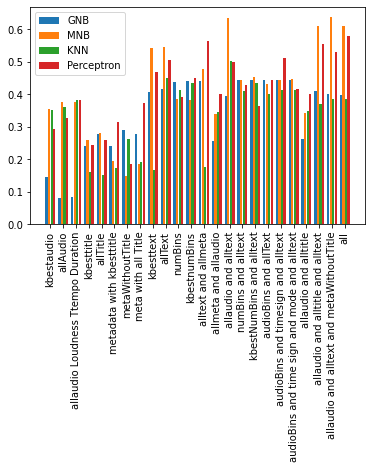

<Figure size 7200x5040 with 0 Axes>

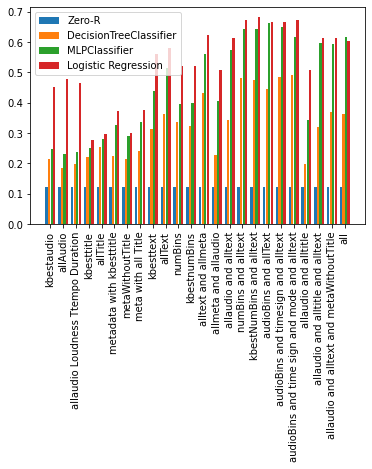

In [22]:
#run plot

labels = list(predicted.keys())#['audio','allAudio']#list(predicted.keys())
title = ['GNB','MNB','KNN','Perceptron']
#['Zero-R','GNB','MNB','KNN','Perceptron','DecisionTreeClassifier','MLPClassifier','Logistic Regression']

val = {}

for x in title:
    val[x] = []
    for y in labels:
        val[x].append(predicted[y][x])

#print(val)

plt.figure(figsize=(100,70))

fig, ax = plt.subplots()
bar_plot(ax, val, total_width=.8, single_width=.9)
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.show()




#evaluation 
#print(predicted)

labels = list(predicted.keys())#['audio','allAudio']#list(predicted.keys())
title = ['Zero-R','DecisionTreeClassifier','MLPClassifier','Logistic Regression']
#['Zero-R','GNB','MNB','KNN','Perceptron','DecisionTreeClassifier','MLPClassifier','Logistic Regression']

val = {}

for x in title:
    val[x] = []
    for y in labels:
        val[x].append(predicted[y][x])

#print(val)

plt.figure(figsize=(100,70))

fig, ax = plt.subplots()
bar_plot(ax, val, total_width=.8, single_width=.9)
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.show()

In [9]:
#best parameter for mlp
def GridMLP(traindata,trainlabel):
    param_grid = {"activation": ['identity', 'tanh', 'relu'],#relu#'logistic', 
                  'hidden_layer_sizes':[(50,25,10),(50,50,50)],#(50, 50, 50)
                  'solver': ['adam'],#adam
                  #'alpha': [0.001, 0.002, 0.003],#0.002
                  'learning_rate': ['constant','adaptive'],#'constant'#'invscaling',
                  #'batch_size' : [10, 20, 30, 40],#20
                  #'max_iter' : [1024, 512, 256]#512
                 }
    
    clf = MLPClassifier()
    gs = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1,
                      verbose=1)
    gs.fit(traindata, trainlabel)
    
    
    print('best_params', gs.best_params_)
    #clf = MLPClassifier(max_iter=2000,**best_params)
    #clf.fit(traindata, trainlabel)
    #print('acc with best params:', clf.score(X_test, y_test))
    return gs.best_params_
    

#GridMLP(pd.concat([traindata['meta'],traindata['audio'],traindata['text']],axis=1),traindata['label'])

In [15]:
#best parameter for logistic regression
def GridLR(traindata,trainlabel):
    param_grid = {#"penalty":['l1', 'l2'],
                  "C":[1,10,1000,2000],#np.logspace(-3,3,3),
                  #"class_weight":[None,'balanced'],
                  "max_iter":range(600,4000,200)
                 }
    
    clf = LogisticRegression()
    gs = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1,
                      verbose=1)
    gs.fit(traindata, trainlabel)
    
    
    print('best_params', gs.best_params_)
    #clf = MLPClassifier(max_iter=2000,**best_params)
    #clf.fit(traindata, trainlabel)
    #print('acc with best params:', clf.score(X_test, y_test))
    return gs.best_params_

#GridLR(pd.concat([traindata['meta'],traindata['audio'],traindata['text']],axis=1),traindata['label'])

In [11]:
#tune decision tree
def GridDT(traindata,trainlabel):
    param_grid = {'max_leaf_nodes': list(range(20,80,5)),#52 
                  'min_samples_split': range(0,80,5),#
                  'max_depth':range(2,20,2),#11
                  'criterion':['gini', 'entropy']#gini
                 }
    
    clf = DecisionTreeClassifier(random_state=0)
    gs = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1,
                      verbose=1)
    gs.fit(traindata, trainlabel)
    
    print('best_params', gs.best_params_)
    #clf = MLPClassifier(max_iter=2000,**best_params)
    #clf.fit(traindata, trainlabel)
    #print('acc with best params:', clf.score(X_test, y_test))
    return gs.best_params_

#GridDT(pd.concat([traindata['meta'],traindata['audio'],traindata['text']],axis=1),traindata['label'])

In [12]:
#Tuned model
def tunedPrediction(traindata, trainlabel, validdata, validlabel, fname,model):
    if model == 'MLP':
        models = [DummyClassifier(strategy='most_frequent'),
                  MLPClassifier(max_iter=2000,**GridMLP(traindata,trainlabel))]
        titles = ['Zero-R','MLPClassifier']
    elif model == 'DT':
        models = [DummyClassifier(strategy='most_frequent'),
                  DecisionTreeClassifier(**GridDT(traindata,trainlabel))]
        titles = ['Zero-R','DecisionTreeClassifier']
    elif model == 'LR':
        models = [DummyClassifier(strategy='most_frequent'),
                  LogisticRegression(**GridLR(traindata,trainlabel))]
        titles = ['Zero-R','Logistic Regression']
    elif model == 'all':
        models = [DummyClassifier(strategy='most_frequent'),
              DecisionTreeClassifier(**GridDT(traindata,trainlabel)),
              MLPClassifier(max_iter=2000,**GridMLP(traindata,trainlabel)),
              LogisticRegression(max_iter=2000,**GridLR(traindata,trainlabel))]
        titles = ['Zero-R','DecisionTreeClassifier','MLPClassifier','Logistic Regression']
    print(fname)
    #score evaluation strategy
    for title, model in zip(titles,models):
        model.fit(traindata,trainlabel)
        #start = time.time()
        acc = model.score(validdata,validlabel)
        
        #acc = np.mean(cross_val_score(model, X, y, cv=10))
        #end = time.time()
        #t = end - start
        #print('time:', t)
        print(title, "Accuracy:",acc)

In [ ]:
#run tuned models
#allAudio and allText #0.4911,0.6511,0.4866
#tunedPrediction(pd.concat([traindata['allAudio'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['allAudio'],validdata['allText']],axis=1),validdata['label'],'allAudio and allText',)
#audio and allTitle and allText #mlp highest score without tuning
###tunedPrediction(pd.concat([traindata['audio'],traindata['allTitle'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['audio'],validdata['allTitle'],validdata['allText']],axis=1),validdata['label'],'audio and allTitle and allText','MLP')
#audioBins and text #logistic regression and decision tree highest score without tuning
#tunedPrediction(pd.concat([traindata['numBins'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['allText']],axis=1),validdata['label'],'numBins and text','all')

###tunedPrediction(pd.concat([traindata['numBins'],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['text']],axis=1),validdata['label'],'numBins and text','DT')

#numBins and timesign and mode and text
#tunedPrediction(pd.concat([traindata['numBins'],traindata['meta'][['time_signature','mode']],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['meta'][['time_signature','mode']],validdata['text']],axis=1),validdata['label'],'numBins and time and mode and text','all')

tunedPrediction(pd.concat([traindata['kbestNumBins'],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['kbestNumBins'],validdata['text']],axis=1),validdata['label'],'kbestnumbins and kbesttext','LR')

#audio 
#tunedPrediction(traindata['audio'],traindata['label'],validdata['audio'],validdata['label'],'audio','all')
#all audio 
#tunedPrediction(traindata['allAudio'],traindata['label'],validdata['allAudio'],validdata['label'],'allAudio','all')
#title
#tunedPrediction(traindata['titleOnly'],traindata['label'],validdata['titleOnly'],validdata['label'],'titleOnly','all')
#all title
#tunedPrediction(traindata['allTitle'],traindata['label'],validdata['allTitle'],validdata['label'],'allTitle','all')
#meta 
#tunedPrediction(traindata['meta'],traindata['label'],validdata['meta'],validdata['label'],'meta','all')
#metaWithoutTitle
#tunedPrediction(traindata['metaWithoutTitle'],traindata['label'],validdata['metaWithoutTitle'],validdata['label'],'metaWithoutTitle','all')
#meta with all Title 
#tunedPrediction(pd.concat([traindata['metaWithoutTitle'],traindata['allTitle']],axis=1),traindata['label'],pd.concat([validdata['metaWithoutTitle'],validdata['allTitle']],axis=1),validdata['label'],'meta with all Title','all')
#text 
#tunedPrediction(traindata['text'],traindata['label'],validdata['text'],validdata['label'],'text','all')
#all text 
#tunedPrediction(traindata['allText'],traindata['label'],validdata['allText'],validdata['label'],'allText','all')
#numbins
#tunedPrediction(traindata['numBins'],traindata['label'],validdata['numBins'],validdata['label'],'allText','all')
#text and meta 
#tunedPrediction(pd.concat([traindata['text'],traindata['meta']],axis=1),traindata['label'],pd.concat([validdata['text'],validdata['meta']],axis=1),validdata['label'],'text and meta','all')
#meta and audio
#tunedPrediction(pd.concat([traindata['meta'],traindata['audio']],axis=1),traindata['label'],pd.concat([validdata['meta'],validdata['audio']],axis=1),validdata['label'],'meta and audio','all')
#audio and text 
#tunedPrediction(pd.concat([traindata['audio'],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['audio'],validdata['text']],axis=1),validdata['label'],'audio and text','all')
#audioBins and text #logistic regression and decision tree highest score without tuning
#tunedPrediction(pd.concat([traindata['numBins'],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['numBins'],validdata['text']],axis=1),validdata['label'],'numBins and text','all')

#all 
#tunedPrediction(pd.concat([traindata['meta'],traindata['audio'],traindata['text']],axis=1),traindata['label'],pd.concat([validdata['meta'],validdata['audio'],validdata['text']],axis=1),validdata['label'],'all','all')
#all all
#tunedPrediction(pd.concat([pd.concat([traindata['metaWithoutTitle'],traindata['allTitle']],axis=1),traindata['allAudio'],traindata['allText']],axis=1),traindata['label'],pd.concat([validdata['meta'],validdata['audio'],validdata['text']],axis=1),validdata['label'],'all all','all')


Fitting 5 folds for each of 68 candidates, totalling 340 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min


In [18]:
def PlotGridMLP(traindata,trainlabel):
    param_grid = {#"activation": ['identity', 'tanh', 'relu'],#relu#'logistic', 
                  'hidden_layer_sizes':[(50,25,10),(50,50,50)],#(50, 50, 50)
                  #'solver': ['adam'],#adam
                  'alpha': [0.001, 0.002, 0.003],#0.002
                  #'learning_rate': ['constant','adaptive'],#'constant'#'invscaling',
                  #'batch_size' : [10, 20, 30, 40],#20
                  #'max_iter' : [1024, 512, 256]#512
                 }

    clf = MLPClassifier()
    gs = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=3,
                      n_jobs=-1,
                      verbose=1)
    gs.fit(traindata, trainlabel)
    print(pd.concat([pd.DataFrame(gs.cv_results_["params"]),pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1))

    return gs.best_params_

PlotGridMLP(pd.concat([traindata['numBins'],traindata['allText']],axis=1),traindata['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  8.6min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  9.6min finished


   alpha hidden_layer_sizes  Accuracy
0  0.001       (50, 25, 10)  0.627639
1  0.001       (50, 50, 50)  0.640791
2  0.002       (50, 25, 10)  0.582572
3  0.002       (50, 50, 50)  0.603412
4  0.003       (50, 25, 10)  0.585436
5  0.003       (50, 50, 50)  0.615395


{'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50)}

In [19]:
#trainAll = pd.concat([traindata['meta'],traindata['audio'],traindata['text']],axis=1)
trainAll = pd.concat([traindata['kbestNumBins'],traindata['text']],axis=1)
lr = LogisticRegression(max_iter=2000,**{'C': 1, 'class_weight': None, 'penalty': 'l2'})
lr.fit(trainAll,traindata['label'])
testAll = pd.concat([testdata['kbestNumBins'],testdata['text']],axis=1)
predict = le.inverse_transform(lr.predict(testAll))
dframe = pd.DataFrame({'trackID': np.array(testdata['trackID']),'genre': predict})
#print(predict)
#print(len(dframe.index))
dframe.to_csv(r'output.csv',index=False)

C:\Users\hidem\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
